In [1]:
using QuCircuit, Plots, BenchmarkTools, Knet

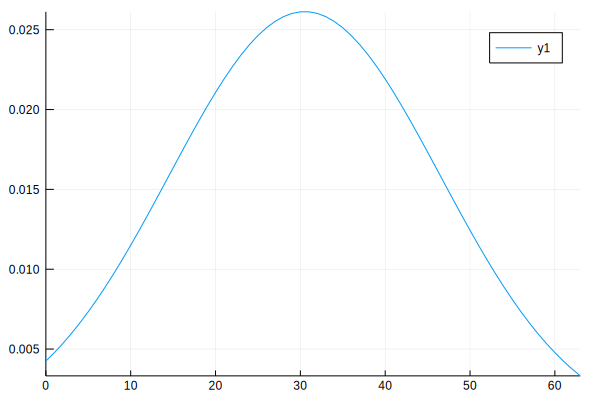

In [2]:
function gaussian_pdf(n, μ, σ)
    x = collect(1:1<<n)
    pl = @. 1 / sqrt(2pi * σ^2) * exp(-(x - μ)^2 / (2 * σ^2))
    pl / sum(pl)
end

num_bit = 6
pg = gaussian_pdf(num_bit, 2^5-0.5, 2^4)
plot(0:1<<num_bit - 1, pg)

## Circuit

In [3]:
function entangler(n, pairs)
    seq = []
    for (ctrl, u) in pairs
        push!(seq, X(u) |> C(ctrl))
    end
    compose(seq)(n)
end

function make_circuit(n, nlayers, pairs)

    first_layer = roll(n, chain(rot(:X), rot(:Z)))
    last_layer = roll(n, chain(rot(:Z), rot(:X)))
    # layer constructor
    # TODO: add cache after empty! is fixed
    layer = roll(chain(rot(:Z), rot(:X), rot(:Z)))

    layers = []
    push!(layers, first_layer)

    for i = 1:(nlayers - 1)
        push!(layers, cache(entangler(n, pairs)))
        push!(layers, layer(n))
    end

    push!(layers, cache(entangler(n, pairs)))
    push!(layers, last_layer)

    chain(layers...)
end

make_circuit (generic function with 1 method)

## Kernel

In [4]:
abstract type AbstractKernel end

struct RBFKernel <: AbstractKernel
    sigmas::Vector{Float64}
    matrix::Matrix{Float64}
end

function RBFKernel(nqubits::Int, sigmas::Vector{Float64}, isbinary::Bool)
    basis = collect(0:(1<<nqubits - 1))
    return RBFKernel(sigmas, rbf_kernel_matrix(basis, basis, sigmas, isbinary))
end

expect(kernel::RBFKernel, px::Vector{Float64}, py::Vector{Float64}) = px' * kernel.matrix * py

# RBF Kernel

function rbf_kernel_matrix(x::Vector, y::Vector, sigmas::Vector{Float64}, isbinary::Bool)
    if length(sigmas) == 0
        throw(DimensionMismatch("At least 1 sigma prameters is required for RBM kernel!"))
    end

    if isbinary
        dx2 = map(count_ones, xor.(x, y'))
    else
        dx2 = (x .- y').^2
    end

    K = 0
    for sigma in sigmas
        gamma = 1.0 / (2 * sigma)
        K = K + exp.(-gamma * dx2)
    end
    return K
end

function mmd_loss(px::AbstractVecOrMat{Float64}, kernel::RBFKernel, py::AbstractVecOrMat{Float64})
    pxy = px - py
    return expect(kernel, pxy, pxy)
end


mmd_loss (generic function with 1 method)

## QCBM

In [5]:
struct QCBM
    n::Int
    nlayers::Int
    circuit

    function QCBM(n, nlayers, pairs)
        new(n, nlayers, make_circuit(n, nlayers, pairs))
    end
end

nparameters(qcbm::QCBM) = 2 * 2 * qcbm.n + (qcbm.nlayers - 1) * 3 * qcbm.n

function (qcbm::QCBM)(params)
    psi = zero_state(nqubit(qcbm.circuit))
    dispatch!(qcbm.circuit, params)
    vec(state(qcbm.circuit(psi)))
end

## Loss & Gradient

In [6]:
function loss(qcbm::QCBM, params, kernel, ptrain)
    prob = abs2.(qcbm(params))
    mmd_loss(prob, kernel, ptrain)
end

import Base: gradient

function gradient(qcbm::QCBM, params, kernel, ptrain)
    tparams = copy(params)
    prob = abs2.(qcbm(tparams))

    grad = zeros(params)
    for i in eachindex(params)
        # pi/2 phase
        tparams = copy(params)
        tparams[i] += pi / 2
        prob_pos = abs2.(qcbm(tparams))

        tparams = copy(params)
        tparams[i] -= pi / 2
        prob_neg = abs2.(qcbm(tparams))

        grad_pos = expect(kernel, prob, prob_pos) - expect(kernel, prob, prob_neg)
        grad_neg = expect(kernel, ptrain, prob_pos) - expect(kernel, ptrain, prob_neg)
        grad[i] = grad_pos - grad_neg
    end
    return grad
end

gradient (generic function with 9 methods)

## Train

In [30]:
function train(qcbm::QCBM, ptrain, optim; learning_rate = 0.1, maxiter=100)
    params = 2pi * rand(nparameters(qcbm))
    kernel = RBFKernel(qcbm.n, [0.25], false)

    losses = Float64[]
    for i = 1:maxiter
        grad = gradient(qcbm, copy(params), kernel, ptrain)
        curr_loss = loss(qcbm, copy(params), kernel, ptrain)
        push!(losses, curr_loss)
        println(i, " step, loss = ", curr_loss)
        update!(params, grad, optim)
    end

    params, losses
end

train (generic function with 2 methods)

In [31]:
function get_nn_pairs(n)
    pairs = []
    for inth in 1:2
        for i in inth:2:n
            push!(pairs, (i, i % n + 1))
        end
    end
    pairs
end

get_nn_pairs (generic function with 1 method)

In [32]:
qcbm = QCBM(6, 10, get_nn_pairs(6));

In [33]:
optim = Adam(lr=0.1)
params, losses = train(qcbm, pg, optim, maxiter=100);

1 step, loss = 0.019532410374712636
2 step, loss = 0.018569467150967356
3 step, loss = 0.010785528409318436
4 step, loss = 0.007522825296648597
5 step, loss = 0.0060888469890466555
6 step, loss = 0.005646582551210459
7 step, loss = 0.005510440163297997
8 step, loss = 0.004458611132996449
9 step, loss = 0.0037351959179649915
10 step, loss = 0.0030924014502014116
11 step, loss = 0.002363305363405659
12 step, loss = 0.0017898258016285059
13 step, loss = 0.0017863840371550707
14 step, loss = 0.0021626239014199237
15 step, loss = 0.0018211886327589738
16 step, loss = 0.0012011929929559688
17 step, loss = 0.0010385892544643837
18 step, loss = 0.0008333431095622298
19 step, loss = 0.0007441191653947644
20 step, loss = 0.0008180947538719525
21 step, loss = 0.0008921115872290796
22 step, loss = 0.0008088001920373297
23 step, loss = 0.0006273446369450073
24 step, loss = 0.0005104788319491207
25 step, loss = 0.00043793614160108263
26 step, loss = 0.0004267277861067215
27 step, loss = 0.0004291451

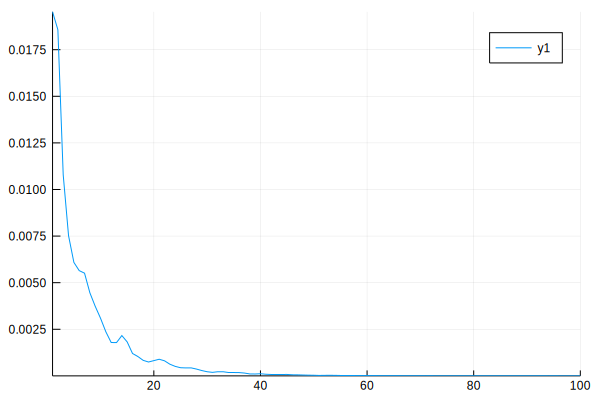

In [34]:
plot(losses)

In [35]:
psi = qcbm(params);

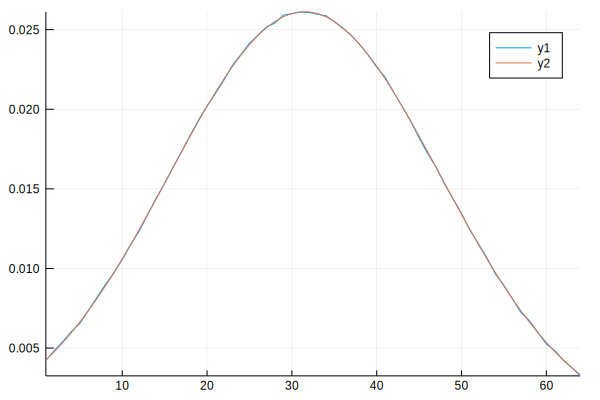

In [36]:
p = abs2.(psi)
p = p / sum(p)
plot([p, pg])